# Baseline Model

## Introducción
En esta notebook se implementa un modelo ML de clasificacion para analizar el cambio


## 1. Importación de Librerías

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind

## 2. Configuración del Entorno

In [2]:
# Configuración de opciones de pandas
pd.set_option('display.max_columns', None)


# Configuración para reproducibilidad
np.random.seed(42)

data_dir = '../data/'
models_dir = '../models/'

## 3. Carga de Datos

In [3]:
df_train=pd.read_parquet(f'{data_dir}df_train_att.parquet')
df_test=pd.read_parquet(f'{data_dir}df_test_att.parquet')
df_val=pd.read_parquet(f'{data_dir}df_val_att.parquet')
df_vo=pd.read_parquet(f'{data_dir}df_vo_att.parquet')

df_train.shape,df_test.shape,df_val.shape,df_vo.shape

((103214, 28), (25668, 28), (32405, 28), (14223, 28))

## 4. Preparación de los Datos para el Modelo Base

In [ ]:
## se va utilizar las mismas variables pero sin hacer tranformaciones , solo para ver el impacto de cambio de modelo

## 5. Pipeline 

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class CustomNumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Transforma los datos aplicando la lógica personalizada.
        """

        X['date']=pd.to_datetime(X['date'])
        X['paymentDate']=pd.to_datetime(X['paymentDate'])
        X['fecha_observacion']=pd.to_datetime(X['fecha_observacion'])
        X['expirationDate']=pd.to_datetime(X['expirationDate'])
        X['paymentDays'] = np.where(X['paymentDate'].isnull(),(X['fecha_observacion'] - X['expirationDate']).dt.days, # fecha de corte "foto"
                                    (X['paymentDate'] - X['expirationDate']).dt.days)
        
        X['amountFinanced']=np.where(X['amountFinanced'].isnull(),713881,X['amountFinanced'])
        X['expirationDays'] = (X['expirationDate'] - X['date']).dt.days

        X['date_paymentDays']=X['expirationDays']+X['paymentDays']


        return X[['amountFinanced',
                'payerSalesSegment',
                'paymentDays',
                'expirationDays',
                'date_paymentDays']]
    
    
    
# Imputación para valores numéricos
numeric_transformer = Pipeline(steps=[
    ('CustomNumerical', CustomNumericalTransformer()),
])

# Imputación para valores categóricos
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])

numerical_features=['date','paymentDate','expirationDate','fecha_observacion','amountFinanced','payerSalesSegment']

categorical_features=['sector']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [28]:
var_primarias=['date',
 'paymentDate',
 'expirationDate',
 'fecha_observacion',
 'amountFinanced',
 'payerSalesSegment',
 'sector']

In [29]:
dense_data = preprocessor.fit_transform(df_train[var_primarias]).toarray() 
#dense_data = transformed_data.toarray() 

df_transformed = pd.DataFrame(dense_data)
df_transformed.shape

(103214, 37)

In [ ]:
# Definir las variables neutrales, negativas y positivas en funcion de correlacion con VD
# para el modelado de modelos de riesgo es muy importante definir los signos esperado de las variables,
var_neu = [
    'amountFinanced',
]

var_neg = [
    'payerSalesSegment',
]

var_pos = [
    'paymentDays',
    'expirationDays',
    'date_paymentDays'
]

# Concatenar todas las variables en una lista
varsstep = var_neu + var_neg + var_pos

# Definir el vector monotónico basado en las listas
monotonic = [0] * len(var_neu) + [-1] * len(var_neg) + [1] * len(var_pos)+[0]*32
len(monotonic)

37

In [6]:
# Importar librerías necesarias
from hyperopt import fmin, hp, tpe, Trials, space_eval
from functools import partial
from hyperopt.pyll import scope

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

In [35]:
var_primarias=['date',
 'paymentDate',
 'expirationDate',
 'fecha_observacion',
 'amountFinanced',
 'payerSalesSegment',
 'sector']

In [48]:
VD='vd'

X_val =preprocessor.fit_transform(df_val[(df_val[VD].isin([0,1]))][var_primarias]).toarray() 
y_val = df_val[(df_val[VD].isin([0,1]))][VD]

X_train =preprocessor.fit_transform(df_train[(df_train[VD].isin([0,1]))][var_primarias]).toarray() 
y_train = df_train[(df_train[VD].isin([0,1]))][VD]

print(X_train.shape, X_val.shape)

(102498, 37) (32163, 36)


In [49]:
common_params = {
    'objective': 'binary',
    'n_jobs': 10,
    'force_col_wise': False,
    'verbose': -1,
    #'class_weight': 'balanced',
   'monotone_constraints': monotonic
}

# Espacio de búsqueda para la optimización de hiperparámetros con Hyperopt
param_space = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 200, 600, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 150, 1)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.1, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 1),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 80, 1)),
    'min_child_weight': hp.uniform('min_child_weight', 0.1, 1.0),
    'max_depth': scope.int(hp.quniform('max_depth', 2, 6, 1)),
    'subsample_freq': scope.int(hp.quniform('subsample_freq', 2, 10, 1)),
    'min_split_gain': hp.uniform('min_split_gain', 0.0, 1.0)
}

# Definir la función de entrenamiento y evaluación del modelo
def train_evaluate_model(hiperparametros, features, target):
    eval_set = [(X_val, y_val)]
    pipe = Pipeline(steps=[('classifier', LGBMClassifier(**common_params, **hiperparametros))])
    
    fit_params = {
        'classifier__eval_set': eval_set,
        'classifier__eval_metric': 'neg_log_loss',
    }
    
    cv = StratifiedKFold(n_splits=4, shuffle=False)
    
    # Validación cruzada
    resultado = cross_val_score(estimator=pipe, 
                                X=features, 
                                y=target, 
                                scoring="f1", 
                                cv=cv, 
                                error_score="raise", 
                                fit_params=fit_params, 
                                n_jobs=10)
    
    return resultado.mean()

In [50]:
import warnings
import logging

# Ignorar el DeprecationWarning de datetime.utcnow
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*datetime.datetime.utcnow.*")

# Ignorar el FutureWarning sobre fit_params
warnings.filterwarnings("ignore", category=FutureWarning, message=".*fit_params.*")

# Reducir los logs de hyperopt.tpe a solo mostrar advertencias y errores
logging.getLogger('hyperopt.tpe').setLevel(logging.WARNING)

# Ejecutar la optimización con Hyperopt
parametros = fmin(fn=partial(train_evaluate_model, features=X_train, target=y_train), 
                  space=param_space, 
                  algo=tpe.suggest, 
                  trials=Trials(), 
                  max_evals=30, 
                  verbose=-1)

100%|██████████| 30/30 [00:26<00:00,  1.13trial/s, best loss: 0.038669758720647325]


In [51]:
# Asignar los parámetros optimizados a 'parametros'
parametros = parametros

# Convertir valores flotantes a enteros si corresponde
for key, value in parametros.items():
    if isinstance(value, float) and value.is_integer():
        parametros[key] = int(value)

# Mostrar los parámetros finales ajustados
parametros

{'colsample_bytree': 0.17556707291894588,
 'learning_rate': 0.0072177803845829246,
 'max_depth': 2,
 'min_child_samples': 42,
 'min_child_weight': 0.8177278441034919,
 'min_split_gain': 0.14989937674087328,
 'n_estimators': 419,
 'num_leaves': 150,
 'reg_alpha': 0.6655783840621714,
 'reg_lambda': 0.42662540871182264,
 'subsample': 0.5574290500799713,
 'subsample_freq': 3}

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

common_params = {
    'objective': 'binary',
    'n_jobs': 10,
    'force_col_wise': False,
    'verbose': -1,
   # 'class_weight': 'balanced',
   'monotone_constraints': monotonic
}
parametros={'colsample_bytree': 0.17556707291894588,
 'learning_rate': 0.0072177803845829246,
 'max_depth': 2,
 'min_child_samples': 42,
 'min_child_weight': 0.8177278441034919,
 'min_split_gain': 0.14989937674087328,
 'n_estimators': 419,
 'num_leaves': 150,
 'reg_alpha': 0.6655783840621714,
 'reg_lambda': 0.42662540871182264,
 'subsample': 0.5574290500799713,
 'subsample_freq': 3}

# Construir el pipeline completo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(**common_params, **parametros))  # Sustituye por el modelo que prefieras
])

var_primarias=['date',
 'paymentDate',
 'expirationDate',
 'fecha_observacion',
 'amountFinanced',
 'payerSalesSegment',
 'sector']

# Entrenar el pipeline
model.fit(df_train[df_train["vd"].isin([0,1])][var_primarias],
           df_train[df_train["vd"].isin([0,1])]['vd'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('CustomNumerical',
                                                                   CustomNumericalTransformer())]),
                                                  ['date', 'paymentDate',
                                                   'expirationDate',
                                                   'fecha_observacion',
                                                   'amountFinanced',
                                                   'payerSalesSegment']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sector'])])),
                ('classifier',
                 LGBMClassi...
                                max_depth=2, min_child_samples=42,
                                min_child_weight=0.8177278441034919,
                                min_split_gain=0.14989937674087328,
                                monotone_constraints=[0, -1, 1, 1, 1, 0, 0, 0,
                                                      0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                      0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                      0, 0, 0, 0, ...],
                                n_estimators=419, n_jobs=10, num_leaves=150,
                                objective='binary',
                                reg_alpha=0.6655783840621714,
                                reg_lambda=0.42662540871182264,
                                subsample=0.5574290500799713, subsample_freq=3,
                                verbose=-1))])

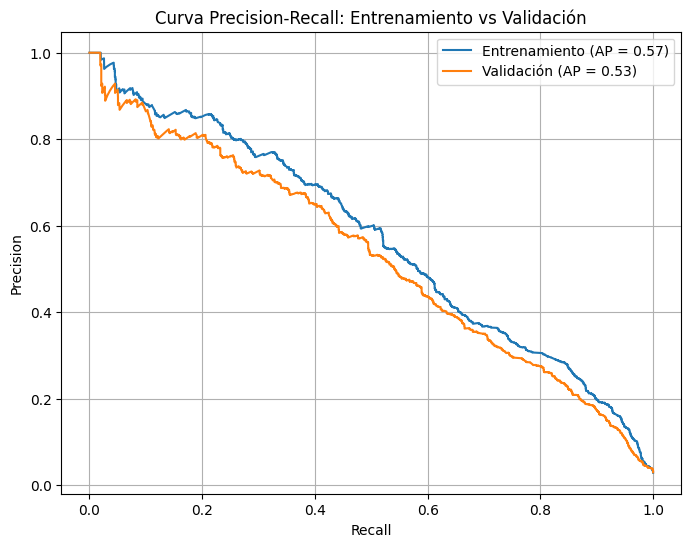

In [ ]:
curva_precision_recall(df_train,pd.concat([df_test,df_val]),model,variables=var_primarias,vd="vd",model_sm=False)
# se observa que el modelo tiene mejor performance que la regresion logistica , 

In [11]:
df_train['score'] = (model.predict_proba(df_train[var_primarias])[:,0]*1000).round().astype(int)
df_val['score'] = (model.predict_proba(df_val[var_primarias])[:,0]*1000).round().astype(int)
df_test['score'] = (model.predict_proba(df_test[var_primarias])[:,0]*1000).round().astype(int)
df_vo['score'] = (model.predict_proba(df_vo[var_primarias])[:,0]*1000).round().astype(int)

### 5.1 desciciones 

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

Profundidad del árbol: 3
Número de nodos terminales: 8


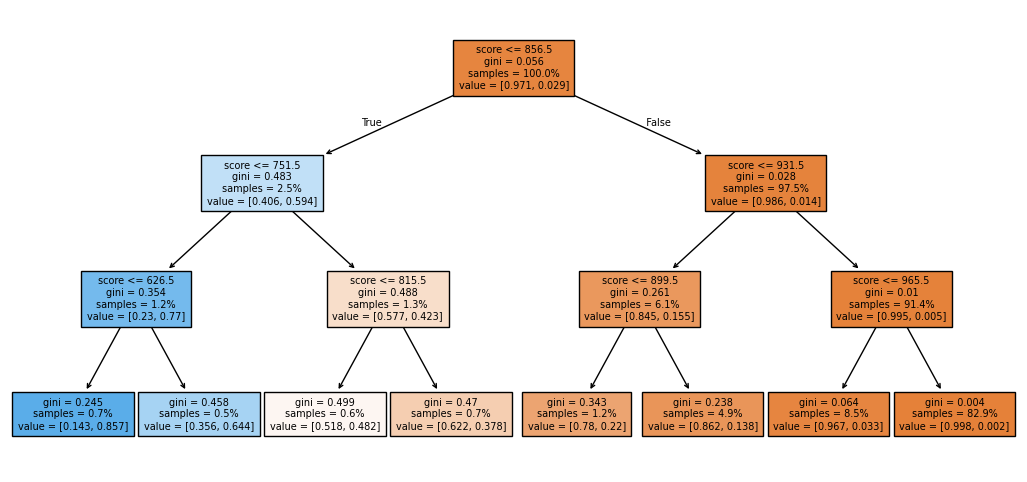

In [56]:
var='score'

X_train=df_train[df_train['vd'].isin([0,1])][[var]]
y_train=df_train[df_train['vd'].isin([0,1])]['vd']

modelo = DecisionTreeClassifier(
            max_depth         = 3,
            criterion         = 'gini',
            random_state      = 123,
            min_samples_split =0.005,
            min_samples_leaf =0.005
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

# Estructura del árbol creado
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = [var],
            #class_names   = var,
            filled        = True,
            impurity      = True,
            fontsize      = 7,
            proportion    = True,
            ax            = ax
       )

In [24]:
def decisiones(df,score='score'):
    df['decisiones']=np.where(df[score]>965,'1 - AAA',
                     np.where(df[score]>931,'2 - AA', 
                    np.where(df[score]>856,'3 - A',  
                    np.where(df[score]>771,'4 - Analiza','5 - Rechaza'))))
    
    return df['decisiones']


df_train['decisiones'] = decisiones(df_train,score='score')
df_val['decisiones'] = decisiones(df_val,score='score')
df_test['decisiones'] = decisiones(df_test,score='score')
df_vo['decisiones'] = decisiones(df_vo,score='score')

In [58]:
tabla_performance(df_train,vd,'score','decisiones')

ks 80.53 auc 95.83 gini 91.66


,score_min,score_max,total,total%,totalCum%,malos,malo%,bad_rate,bad_rateCum
decisiones,,,,,,,,,
1 - AAA,966,993,84940,0.827230,0.827230,173,0.055254,0.002037,0.002037
2 - AA,932,965,8749,0.085206,0.912437,288,0.091983,0.032918,0.004921
3 - A,857,931,6255,0.060917,0.973354,977,0.312041,0.156195,0.014388
4 - Analiza,772,856,1204,0.011726,0.985080,515,0.164484,0.427741,0.019308
5 - Rechaza,326,771,1532,0.014920,1.000000,1178,0.376238,0.768930,0.030493


In [59]:
tabla_performance(pd.concat([df_val,df_test]),vd,'score','decisiones')

ks 77.82 auc 94.79 gini 89.58


,score_min,score_max,total,total%,totalCum%,malos,malo%,bad_rate,bad_rateCum
decisiones,,,,,,,,,
1 - AAA,966,993,47409,0.820921,0.820921,143,0.078228,0.003016,0.003016
2 - AA,932,965,5172,0.089557,0.910478,195,0.106674,0.037703,0.006428
3 - A,857,931,3611,0.062527,0.973005,554,0.303063,0.153420,0.015874
4 - Analiza,772,856,687,0.011896,0.984901,284,0.155361,0.413392,0.020675
5 - Rechaza,312,771,872,0.015099,1.000000,652,0.356674,0.747706,0.031653


### Modelo de regresion logistica
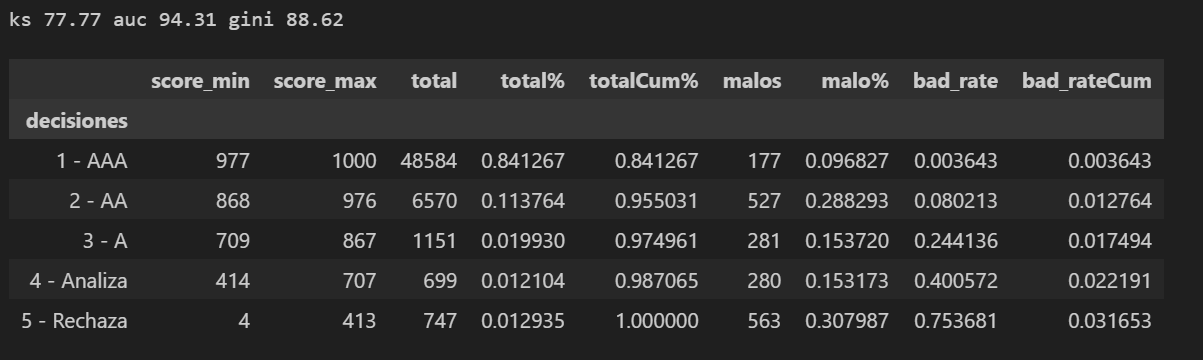

In [22]:
# se observa en la tabla de validacion performance similares pero con mejor % del total AAA y Rechazar manteniendo bad rate, 

In [25]:
tabla_performance(df_vo,vd,'score','decisiones')

ks 89.88 auc 98.51 gini 97.02


,score_min,score_max,total,total%,totalCum%,malos,malo%,bad_rate,bad_rateCum
decisiones,,,,,,,,,
1 - AAA,966,992,10398,0.761479,0.761479,8,0.010458,0.000769,0.000769
2 - AA,932,965,1335,0.097766,0.859246,11,0.014379,0.008240,0.001619
3 - A,857,931,954,0.069865,0.929110,78,0.101961,0.081761,0.007646
4 - Analiza,773,856,266,0.019480,0.948590,125,0.163399,0.469925,0.017139
5 - Rechaza,312,771,702,0.051410,1.000000,543,0.709804,0.773504,0.056023


### 5.2 Importancia Variables 

In [12]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
# para analizar el impacto se puede tomar la base de val que es menor, ya que los calculos de shap suelen demorar
df_tranf=model.named_steps['preprocessor'].transform(df_val[var_primarias]).toarray() 

In [14]:
modelo_clf=model.named_steps['classifier']

var_sector=model.named_steps['preprocessor'].named_transformers_['cat']['onehot'].categories_[0].tolist()
var_modelo=['amountFinanced',
 'payerSalesSegment',
 'paymentDays',
 'expirationDays',
 'date_paymentDays']+var_sector

clf_exp=shap.TreeExplainer(
    modelo_clf,
    df_tranf,
    feature_names=var_modelo
    
)

shap_exp_values_clf=clf_exp(df_tranf)

100%|===================| 32326/32405 [00:42<00:00]        

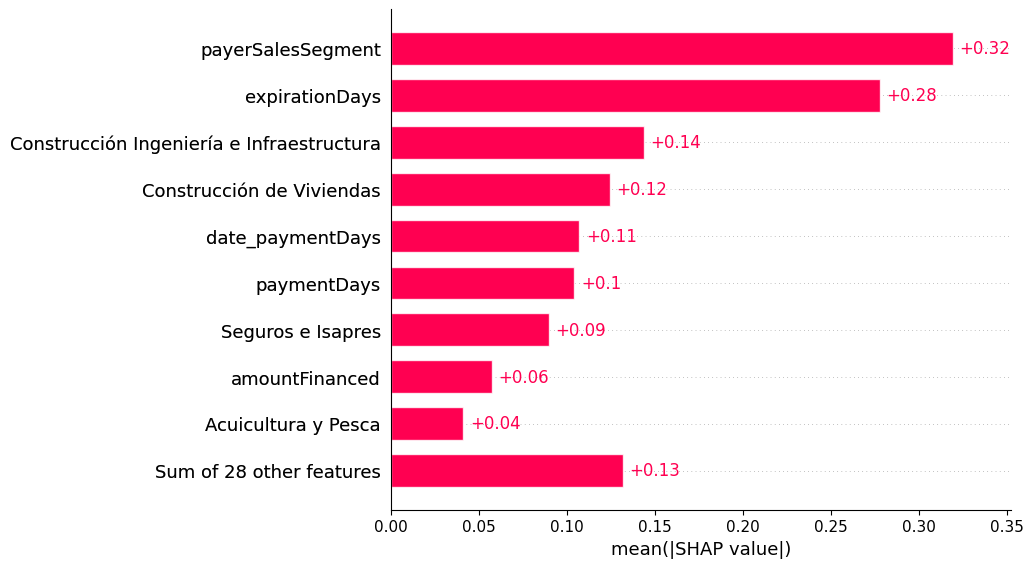

In [15]:
shap.plots.bar(shap_exp_values_clf)

In [ ]:
## La variable mas importante mediante la tecnica shap value es payerSalesSegment y de expirationDays 

# donde 
# payerSalesSegment : 
# expirationDays es los dias desde vencimiento de la factura hasta el pago o fecha de observacion 
# se aprecia por esta tecnica que el sector de construccion es mas propenso a pasar atrasado o caer en default


### 5.3 Simulaciones

In [19]:
varsstep=['amountFinanced',
 'payerSalesSegment',
 'paymentDays',
 'expirationDays',
 'date_paymentDays']+var_sector

In [20]:
X_preprocessor=pd.DataFrame(model.named_steps['preprocessor'].transform(df_train[var_primarias].sample(n=500)).toarray(),columns=varsstep)
modelo_classifier=model.named_steps['classifier']
X_preprocessor.head()

,amountFinanced,payerSalesSegment,paymentDays,expirationDays,date_paymentDays,Acuicultura y Pesca,Aerolíneas,Agricultura y Relacionados,Combustibles y Gas,Comercio,Construcción Ingeniería e Infraestructura,Construcción de Viviendas,Consumo Basico,Educación,Energía,Envíos y Almacenamiento,Ganadería,Gobierno y Actividades Sociales,"Hoteles, Restaurantes y Ocio",Industria Automotriz,Laboratorios y Fabricación Productos Farmacéuticos,Maquinaria y Equipo,Medios de Comunicación,Mercados de Capitales,Minería y Metales,Quimicos y Maderas,Relacionados a Construccion,Retail,Seguros e Isapres,Servicios,Servicios de Salud,Suministro de Agua,Tabaco,Tecnología de la Información,Telecomunicaciones,Transporte,None
0,6763044.0,5.0,-6.0,53.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1139169.0,5.0,11.0,30.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4081700.0,2.0,4.0,31.0,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11609045.0,5.0,15.0,61.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,148155.0,5.0,-10.0,32.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


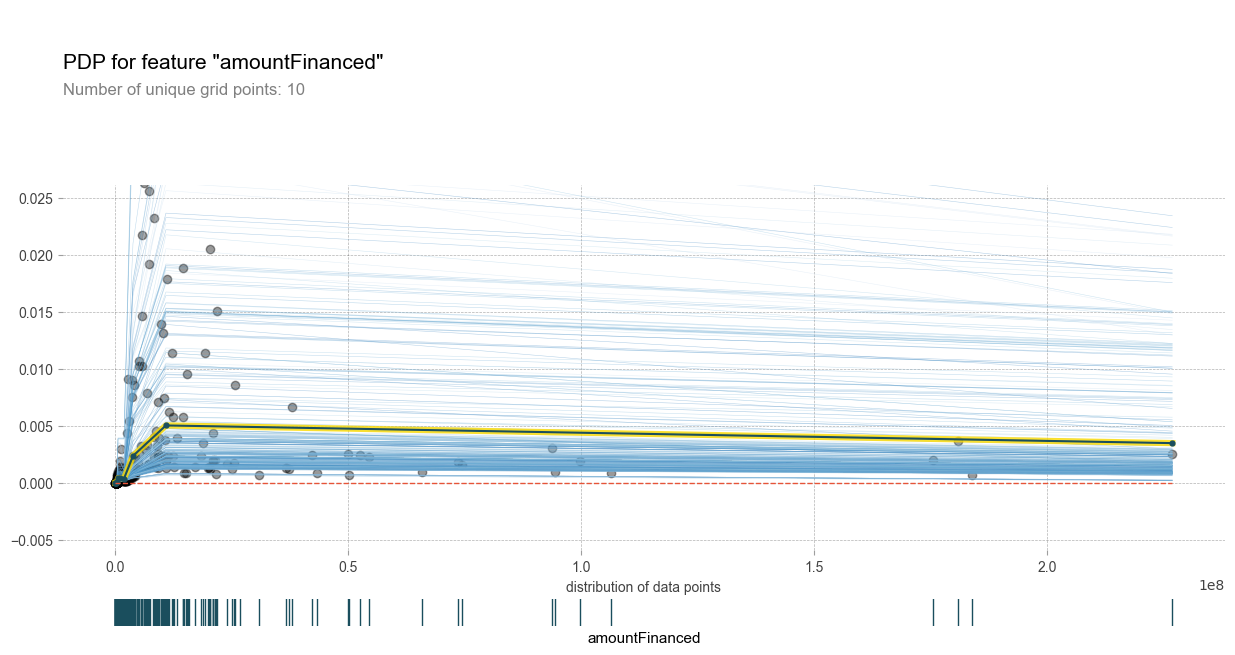

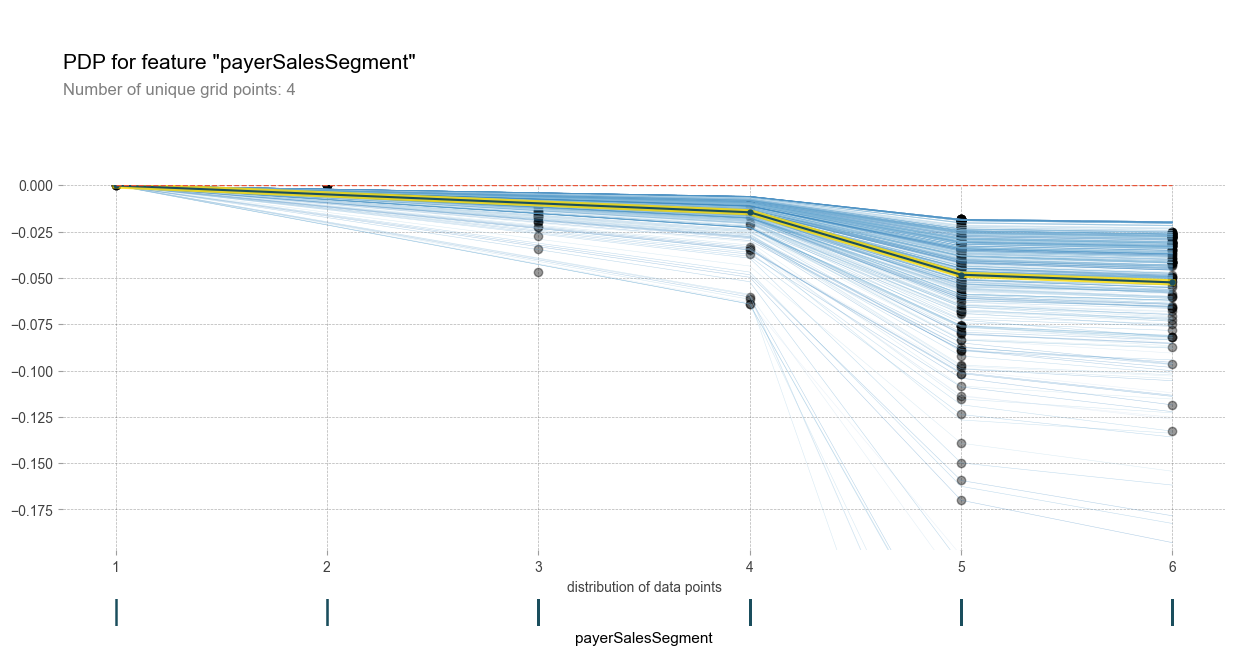

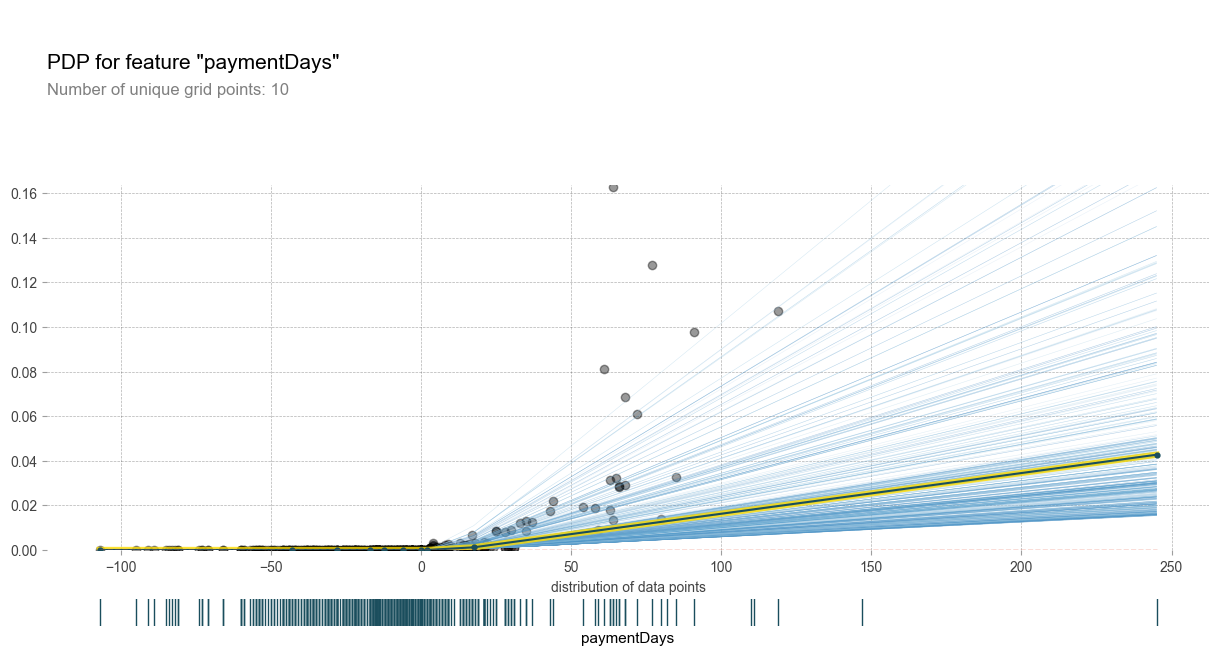

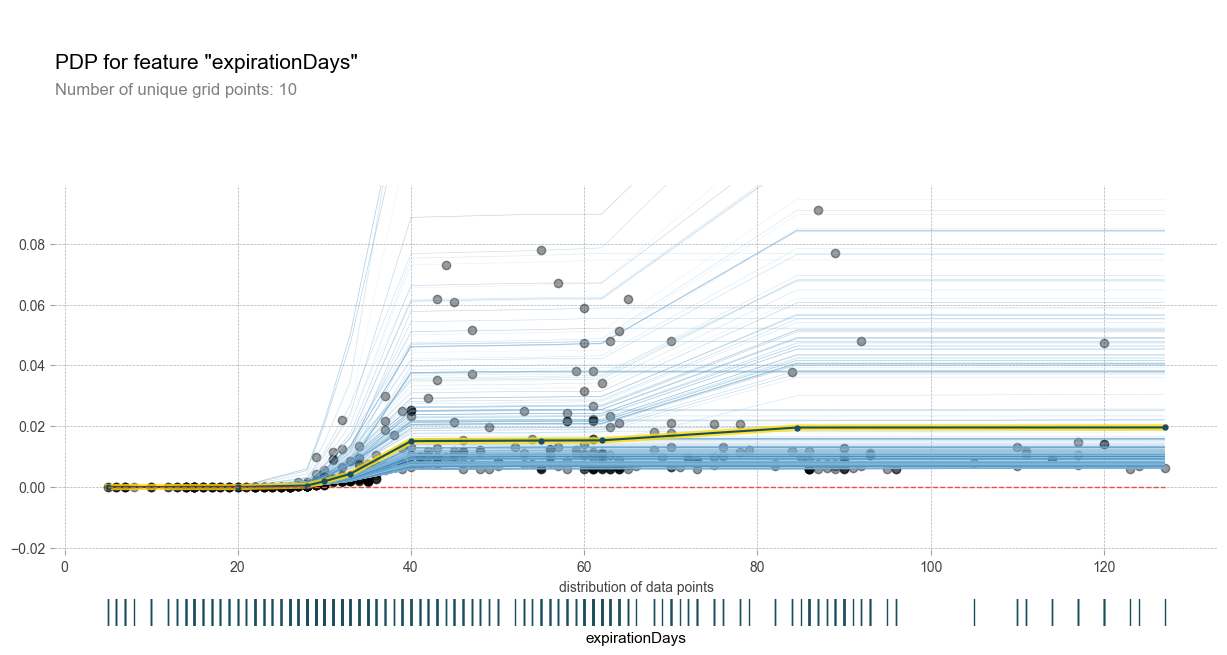

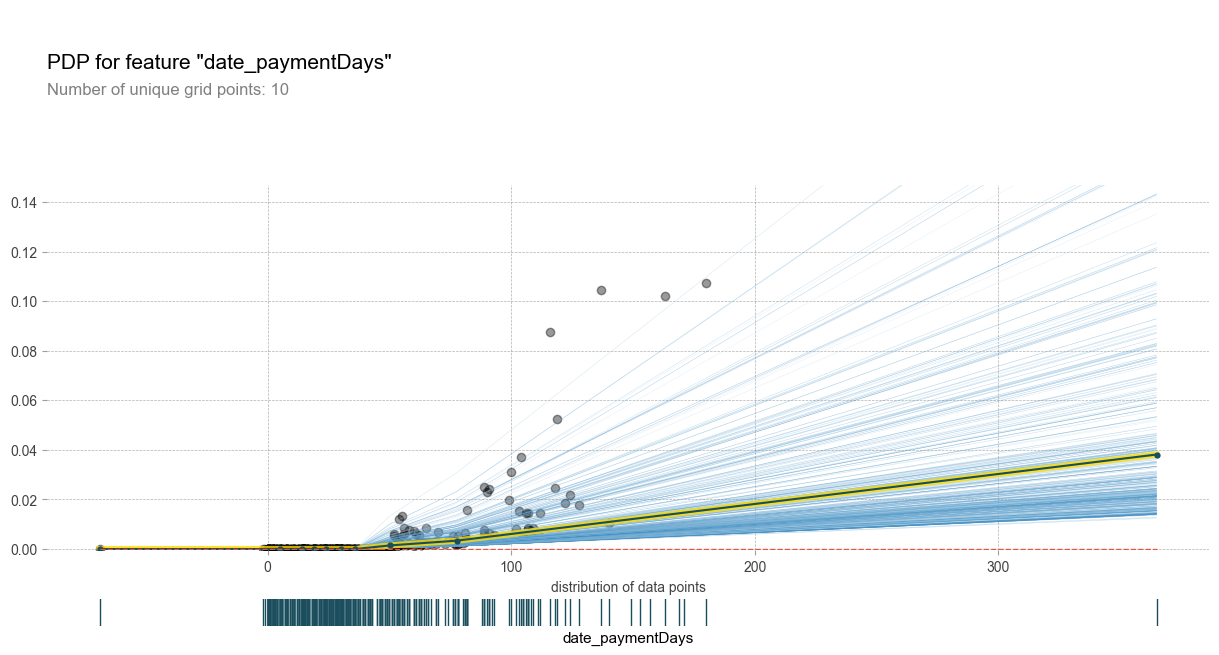

In [21]:
from pdpbox import pdp
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Desactivar las advertencias sobre la fuente 'Arial'
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


var_plot=['amountFinanced',
 'payerSalesSegment',
 'paymentDays',
 'expirationDays',
 'date_paymentDays']


# Iterar sobre las variables a analizar
for var_analisis in var_plot:


    # Cálculo de las curvas ICE (Individual Conditional Expectation)
    ice_df = pdp.pdp_isolate(
        model=modelo_classifier,
        dataset=X_preprocessor,
        feature=var_analisis,
        model_features=varsstep,
        grid_type="percentile",  # Tipo de discretización de los puntos
    )

    # Generación del gráfico PDP
    fig, axes = pdp.pdp_plot(
        ice_df,
        feature_name=var_analisis,
        center=True,
        plot_pts_dist=True,
        plot_lines=True,
        frac_to_plot=1,
        x_quantile=False,
        show_percentile=False,
        figsize=(15, 8),
        ncols=2,
        which_classes=None,
        #plot_params=plot_params,
    )

    # Agregar scatter de puntos reales versus diferencias de predicción
    axes["pdp_ax"]["_pdp_ax"].scatter(
        X_preprocessor[var_analisis],
        modelo_classifier.predict_proba(X_preprocessor)[:, 1] -
        ice_df.ice_lines.transpose().iloc[0, :],
        color="k",
        alpha=0.4,
    )

    # Mostrar los gráficos
    plt.show()


In [ ]:
# Se observa que el modelo maneja mejor las variables no lineales, payerSalesSegment se ve que para valor 5 y 6 la probabilidad default disminuy significativamente
# en cuanto expirationDays entre valores de 30 y 40 tiene un cambio significativo y para valores mas de 40 no cambia mucho la probabilidad de default

## 6. Conclusiones modelo advanced

1. **Enfoque del modelo avanzado:**
   - Se utilizó el mismo conjunto de variables que en el modelo base, pero sin aplicar transformaciones adicionales, con el objetivo de analizar el impacto del cambio de modelo.
   - Para la variable categórica `sector`, se aplicó codificación OneHotEncoder para representar las categorías de manera efectiva.

2. **Definición de signos esperados:**
   - En el modelado de riesgo, es crucial definir los signos esperados de las variables para garantizar que los resultados sean coherentes y alineados con el conocimiento del negocio.

3. **Optimización de hiperparámetros:**
   - Se empleó `Hyperopt` para buscar parámetros óptimos en un espacio de búsqueda conservador, con el objetivo de evitar modelos excesivamente complejos y garantizar la interpretabilidad.
   - El modelo final seleccionado fue un **LightGBM** con parámetros simples, como:
     - **`max_depth` = 2**
     - **`learning_rate` = 0.0072**
   - Este enfoque permite un modelo eficiente y manejable sin sacrificar el desempeño.

4. **Desempeño del modelo:**
   - En la tabla de validación, se observaron resultados similares al modelo de regresión logística en términos generales, pero el modelo **LightGBM** mostró mejoras:
     - Mayor porcentaje de registros clasificados como `AAA` y `Rechazar`, manteniendo un `bad rate` consistente.
     - Mejor manejo de relaciones no lineales entre las variables predictoras y la probabilidad de default.

5. **Análisis de importancia de variables (SHAP Values):**
   - Las variables más relevantes según los valores SHAP fueron:
     - **`payerSalesSegment`:** Segmento de ventas del pagador.
     - **`expirationDays`:** Días desde el vencimiento de la factura hasta el pago o la fecha de observación.
   - Observaciones destacadas:
     - El sector de construcción se identificó como más propenso a retrasos o defaults.
     - `payerSalesSegment` mostró que para los valores 5 y 6, la probabilidad de default disminuye significativamente.
     - Para `expirationDays`, entre 30 y 40 días se observa un cambio significativo en la probabilidad de default, mientras que valores mayores a 40 días no tienen un impacto tan marcado.

6. **Capacidades del modelo avanzado:**
   - **Mejor manejo de no linealidades:**
     - Comparado con la regresión logística, el modelo **LightGBM** captura mejor las relaciones no lineales en los datos.
   - **Impacto en variables clave:**
     - `payerSalesSegment` y `expirationDays` mostraron interacciones y patrones no lineales significativos que el modelo logró interpretar adecuadamente.

7. **Conclusión general:**
   - El modelo avanzado con LightGBM demostró un desempeño sólido, con mejoras notables en la clasificación y manejo de no linealidades respecto al modelo base.
   - Aunque el modelo actual es robusto, futuras iteraciones podrían explorar la incorporación de nuevas variables y ajustes adicionales en los hiperparámetros para mejorar aún más su precisión y estabilidad.

---

Con este modelo avanzado, se obtiene una herramienta más flexible y precisa para predecir el comportamiento de default, destacando la capacidad de LightGBM para manejar relaciones complejas en los datos.





In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
def curva_roc(dev,val,modelo,variables=[],vd="vd",model_sm=True):
    
    y_train=dev[dev[vd].isin([0,1])][vd]
    y_valid=val[val[vd].isin([0,1])][vd]

    if model_sm:
        X_dev=sm.add_constant(dev[dev[vd].isin([0,1])][variables], prepend=True)
        X_val=sm.add_constant(val[val[vd].isin([0,1])][variables], prepend=True)

        y_train_scores=modelo.predict(exog = X_dev)
        y_valid_scores=modelo.predict(exog = X_val)
    else:

        y_train_scores=modelo.predict_proba(dev[dev[vd].isin([0,1])][variables])[:,1]
        y_valid_scores=modelo.predict_proba(val[val[vd].isin([0,1])][variables])[:,1]

    # Calcular la curva ROC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
    roc_auc_train = roc_auc_score(y_train, y_train_scores)

    # Curva ROC para validación
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_scores)
    roc_auc_valid = roc_auc_score(y_valid, y_valid_scores)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f"Entrenamiento (AUC = {roc_auc_train:.2f})")
    plt.plot(fpr_valid, tpr_valid, label=f"Validación (AUC = {roc_auc_valid:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Adivinanza Aleatoria")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC: Entrenamiento vs Validación")
    plt.legend()
    plt.grid()
    plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
def curva_precision_recall(dev,val,modelo,variables=[],vd="vd",model_sm=True):
    
    y_train=dev[dev[vd].isin([0,1])][vd]
    y_valid=val[val[vd].isin([0,1])][vd]

    if model_sm:

        X_dev=sm.add_constant(dev[dev[vd].isin([0,1])][variables], prepend=True)
        X_val=sm.add_constant(val[val[vd].isin([0,1])][variables], prepend=True)

        y_train_scores=modelo.predict(exog = X_dev)
        y_valid_scores=modelo.predict(exog = X_val)
    else:

        y_train_scores=modelo.predict_proba(dev[dev[vd].isin([0,1])][variables])[:,1]
        y_valid_scores=modelo.predict_proba(val[val[vd].isin([0,1])][variables])[:,1]


    # Calcular la curva ROC
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    ap_train = average_precision_score(y_train, y_train_scores)

    # Curva Precision-Recall para validación
    precision_valid, recall_valid, _ = precision_recall_curve(y_valid, y_valid_scores)
    ap_valid = average_precision_score(y_valid, y_valid_scores)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(recall_train, precision_train, label=f"Entrenamiento (AP = {ap_train:.2f})")
    plt.plot(recall_valid, precision_valid, label=f"Validación (AP = {ap_valid:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precision-Recall: Entrenamiento vs Validación")
    plt.legend()
    plt.grid()
    plt.show()    

vd='vd'
score="score"
desciones='payerSalesSegment'

from sklearn.metrics import roc_curve, roc_auc_score

def tabla_performance(df,vd,score,desciones):

    df=df[df[vd].isin([0,1,2])].copy()
    df['vd']=np.where(df[vd]==2,1,df[vd])

    df = df.sort_values(by=score, ascending=True)

    df['cum_bad'] = df[vd].cumsum() / df[vd].sum()
    df['cum_good'] = (1 - df[vd]).cumsum() / (1 - df[vd]).sum()
    df['ks'] = df['cum_bad'] - df['cum_good']


    ks_value = round(df['ks'].max()*100,2)
    auc = round(roc_auc_score(df[vd], 1000-df[score])*100,2)
    gini = round((2 * auc/100 - 1)*100,2)

    print(f"ks {ks_value}",f"auc {auc}",f"gini {gini}")


    df_tmp=df.groupby([desciones]).agg(
        score_min=(score,'min'),
        score_max=(score,'max'),
        malos=(vd,'sum'),
        total=(vd,'size'),
    )
    df_tmp["bad_rate"]=df_tmp["malos"]/df_tmp["total"]
    df_tmp["malo%"]=df_tmp["malos"]/df_tmp["malos"].sum()
    df_tmp["maloCum"]=df_tmp['malos'].cumsum()

    df_tmp["total%"]=df_tmp["total"]/df_tmp["total"].sum()
    df_tmp["totalCum"]=df_tmp['total'].cumsum()
    df_tmp["totalCum%"]=df_tmp['total%'].cumsum()
    df_tmp["bad_rateCum"]=df_tmp["maloCum"]/df_tmp["totalCum"]

    return df_tmp[["score_min","score_max",'total','total%',"totalCum%",'malos',"malo%",'bad_rate','bad_rateCum']]